In [1]:
%load_ext jupyter_black

# TS Lab Classification

In this laboratory work, you will classify heart sound recordings.

## General Rules

- You can work in small groups: 1-2 people
- Deadline: 18.12.24 23:59
- To estimate performance of the algorithm you should report the following metrics:
    - Accuracy, Precision, Recall
    - AUC-ROC, F1-Score
- You should submit a Jupyter notebook with brief descriptions of what happens in each cell.

In this task your goal is to develop an interpretable model/algorithm for classifying heart sound recordings
of abnormal and normal hearts. It means that you need to apply some clever feature engineering techniques.

[HINT: Theoretically, recording a normal heart rate should behave like a normal time series with fairly
simple deterministic dynamics. However, in an abnormal situation, the recording of the heartbeat may
shift to a chaotic area.]

You are allowed to use very simple ML models such as logistic regression, SVM, decision tree. The optimal
result would be to find a feature space in which the classes are linearly separable.

## Grading

1. (0-8 points) Implement algorithms for computing Lyaupunov exponents, Entropy-Complexity plane,
Kolmogorov-Sinai entropy, fractal dimension, Hurst exponent. Use obtained values as features. Try
different combinations. Report the results. You may also consider using some preprocessing (fre-
quency filtration).

2. (0-2 points) Train a CNN on spectrograms of sound recordings. Compare the results.

In [2]:
import os
import warnings
from os.path import join

import numpy as np
import numba as nb
import pandas as pd
from scipy.io import arff
from tqdm.auto import tqdm, trange
from numba import jit, prange
from statsmodels.tsa.stattools import acf


warnings.filterwarnings("error")
nb.set_num_threads(8)
np.random.seed(42)

## Loading in the dataset

I read the data from arff files and display it so it is clear what I an working with.

In [3]:
data_path = join(os.getcwd(), "data")

train, _ = arff.loadarff(join(data_path, f"AbnormalHeartbeat_TRAIN.arff"))
test, _ = arff.loadarff(join(data_path, f"AbnormalHeartbeat_TEST.arff"))

target_dict = {"Normal".encode("utf-8"): 0, "Abnormal".encode("utf-8"): 1}

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
df_test["target"] = df_test["target"].map(target_dict)
df_train["target"] = df_train["target"].map(target_dict)
df_train

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att18522,att18523,att18524,att18525,att18526,att18527,att18528,att18529,att18530,target
0,-0.020874,-0.045197,-0.043945,-0.049011,-0.046600,-0.048004,-0.045563,-0.041962,-0.037170,-0.029541,...,-0.044037,-0.041382,-0.040192,-0.036194,-0.034424,-0.032532,-0.032501,-0.031982,-0.033783,1
1,-0.004303,-0.009003,-0.008728,-0.009918,-0.009949,-0.010681,-0.010773,-0.011200,-0.011230,-0.011169,...,0.016815,0.016846,0.016754,0.015839,0.015930,0.015961,0.016205,0.016357,0.017792,1
2,-0.006073,-0.012054,-0.009979,-0.010742,-0.009888,-0.010406,-0.010101,-0.009979,-0.010162,-0.010315,...,-0.006775,0.001740,0.010071,0.017914,0.025574,0.032959,0.039673,0.044739,0.050018,1
3,0.007202,0.015594,0.013245,0.015594,0.015015,0.017792,0.018250,0.020660,0.021240,0.022797,...,0.040466,0.037994,0.036011,0.033295,0.032074,0.030304,0.030426,0.030212,0.031219,1
4,-0.024231,-0.051056,-0.045929,-0.049835,-0.048828,-0.049316,-0.048401,-0.047913,-0.046051,-0.045837,...,-0.277618,-0.294800,-0.303314,-0.309082,-0.314179,-0.310944,-0.304504,-0.298065,-0.282532,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-0.032227,-0.056732,-0.034149,-0.024109,-0.005127,0.007629,0.023743,0.037292,0.051758,0.064087,...,-0.020721,-0.020233,-0.019501,-0.018433,-0.018005,-0.017151,-0.014282,-0.008087,-0.007111,0
200,0.002380,0.005127,0.005737,0.007263,0.008575,0.010742,0.012970,0.017212,0.022003,0.027954,...,0.005707,0.006683,0.006012,0.003601,0.000427,-0.001984,-0.003998,-0.005981,-0.007660,0
201,-0.008881,-0.019379,-0.018250,-0.020325,-0.019989,-0.021271,-0.020905,-0.021423,-0.022522,-0.023438,...,0.115173,0.112854,0.108795,0.103119,0.095245,0.086121,0.073975,0.059906,0.043701,0
202,0.024139,0.049408,0.035004,0.030121,0.021027,0.012146,0.010773,0.009216,0.009735,0.006683,...,-0.049042,-0.042694,-0.037415,-0.028961,-0.019653,-0.009369,0.000275,0.009033,0.018524,0


Let us check if there is class imbalance on this dataset:

In [4]:
df_train["target"].value_counts() / df_train.shape[0]

target
1    0.730392
0    0.269608
Name: count, dtype: float64

In [5]:
df_test["target"].value_counts() / df_test.shape[0]

target
1    0.731707
0    0.268293
Name: count, dtype: float64

## ACF plots

Take a look at ACF plots. They seem to be smooth enough for me to use the intermediate value theorem (теорему Больцано-Коши) to find their zeros

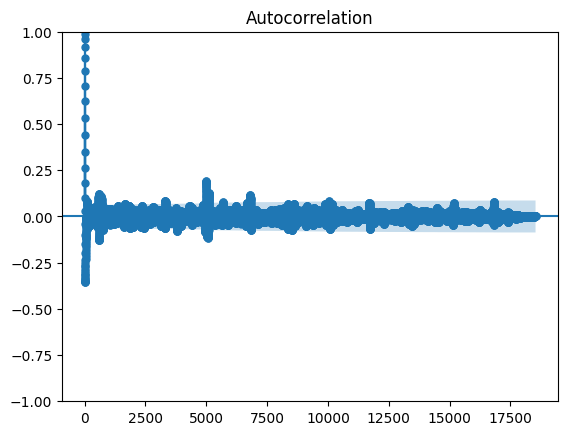

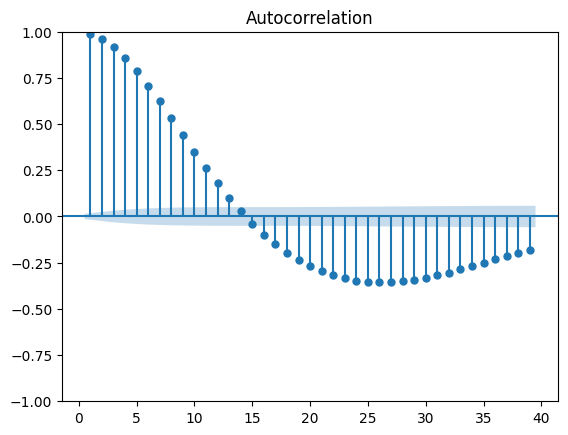

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_train.iloc[203, :-1], lags=np.arange(1, 18_530))
plot_acf(df_train.iloc[203, :-1], lags=np.arange(1, 40))
pass

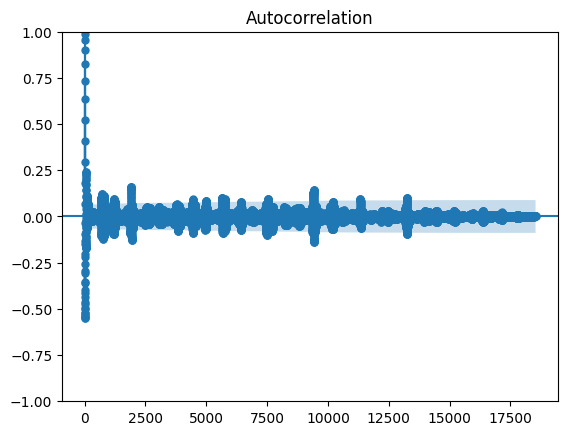

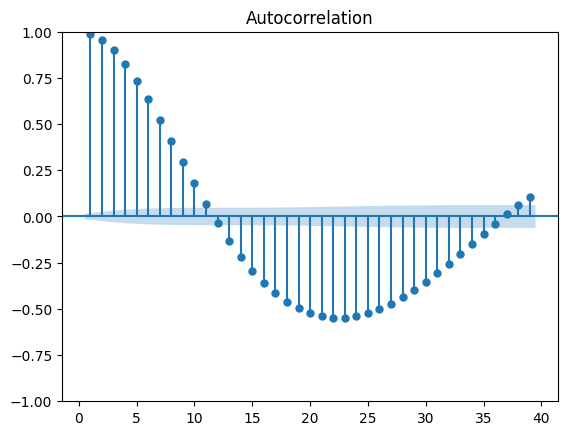

In [7]:
plot_acf(df_train.iloc[10, :-1], alpha=0.05, lags=np.arange(1, 18_530))
plot_acf(df_train.iloc[10, :-1], alpha=0.05, lags=np.arange(1, 40))
pass

## Parameter extraction

Let us try extracting Lyapunov exponents using local linear maps method. For this we would also need a method of extracting the optimal $\tau$ and `m`:

- I define $\tau$ as the lag that produces the first zero of ACF function;

- and I define `m` as the first embedding size that produces a proportion of false nearest neighbours of $<5\%$.

Other parameters for the algorithm were determined heuristically.

**Note:** Even though this implementation uses parallelization techniques to save on inference time, it still takes ~30 mins to fully run this notebook and your PC **will** be closer to an airplane than a PC. This is why **I use the same `m` for all series at inference time**.

In [8]:
def get_tau(series, nlags: int = 100):
    """
    Find the best lag
    """
    acf_values = acf(series, nlags)
    for lag in range(1, nlags + 1):
        if acf_values[lag - 1] * acf_values[lag] < 0:
            return (
                lag - 1
                if np.abs(acf_values[lag - 1]) < np.abs(acf_values[lag - 1])
                else lag
            )
    return np.argmin(acf_values)


@jit(nopython=True, cache=True)
def knn(Y, cand_idx, target, k: int):
    """
    Find k nearest neighbourse using euclidean distance.
    """
    permutation = np.argsort(
        np.array([np.linalg.norm(Y[i, :] - target) for i in cand_idx])
    )
    topk_ids = cand_idx[permutation]
    return topk_ids[-k:]


@jit(nopython=True, cache=True, parallel=True)
def get_weights(
    Y,
    A,
    b,
    W: int,
    k: int,
    n_epochs: int,
    lr: float,
    tol: float,
):
    """
    Function that updates the weights for local linear maps algorithm
    """
    for idx in prange(len(Y)):
        if idx <= W:
            cand_idx = np.arange(idx + W + 1, len(Y))
        elif idx >= len(Y) - 1 - W:
            cand_idx = np.arange(0, idx - W)
        else:
            cand_idx = np.concatenate(
                (np.arange(0, idx - W), np.arange(idx + W + 1, len(Y)))
            )
        topk_ids = knn(Y, cand_idx, Y[idx, :], k)
        neighborhood = Y[topk_ids]
        target = Y[np.array([min(idx + 1, len(Y) - 1) for idx in topk_ids])]

        loss_hist = nb.typed.List.empty_list(np.float64)
        for epoch in range(n_epochs):
            diffs = neighborhood @ A[idx, :] + b[idx, :].reshape(-1, 1) - target

            mean_diffs = np.zeros((diffs.shape[1]))
            for j in range(diffs.shape[1]):
                mean_diffs[j] = np.mean(diffs[j, :])
            loss_hist.append(np.linalg.norm(mean_diffs))
            if len(loss_hist) > 1:
                if np.abs(loss_hist[-2] - loss_hist[-1]) < tol:
                    break

            A[idx, :] -= lr * (neighborhood.T @ diffs)
            b[idx, :] -= lr * diffs.sum()


@jit(nopython=True, cache=True, parallel=True)
def get_fnn(Y, m, R_A, tau):
    """
    A function that returns the amount of false nearest neighbours.
    The conditions used to determine false nearest neighbors are taken from the original article Kennel et al. (1992)
    """
    fnn_cnt = 0
    for idx in prange(len(Y) - tau):
        if idx == 0:
            cand_idx = np.arange(idx + 1, len(Y) - 1)
        elif idx == len(Y) - 1:
            cand_idx = np.arange(0, idx)
        else:
            cand_idx = np.concatenate(
                (np.arange(0, idx), np.arange(idx + 1, len(Y) - 1))
            )

        j = knn(Y, cand_idx, idx, k=1)[0]  # find nearest neighbor

        # Check whether adding a dimension signifiantly changes
        # the nearest neighbor
        R_d = np.linalg.norm(Y[idx, :] - Y[j, :])
        r_i = np.abs(Y[idx + m * tau, -1] - Y[j + m * tau, -1]) / R_d
        if r_i > 1.5 or (R_d + np.abs(Y[idx + tau, -1] - Y[j + tau, -1])) / R_A > 15.0:
            fnn_cnt += 1
    return fnn_cnt


def get_emb_size(series, tau: int, max_size: int = 10):
    ans = max_size
    R_A = series.std()
    for m in range(1, max_size + 1):
        Y = np.array(
            [series[i : i + m * tau : tau] for i in range(len(series) - (m - 1) * tau)]
        )
        fnn_cnt = get_fnn(Y, m, R_A, tau)
        if fnn_cnt / len(Y) < 0.05:
            ans = m
            break
    return ans


class LocalLinearMaps:
    def __init__(
        self,
        m: int | None = None,
        tau: int | None = None,
        W: int = 100,
        n_iter: int = 1_000,
        T: int = 50,
        n_epochs: int = 100,
        lr: float = 1e-3,
        tol: float = 1e-6,
    ):
        """
        params:
                 m : embedding dimension
                 k : number of nearest neighbors for building the local model
               tau : time delay
                 W : temporal correlation exclusion window
            n_iter : number of algorithm iterations
                 T : reorthogonalization period
          n_epochs : number of SGD epochs
                lr : SGD learning rate
               tol : SGD tolerance

        note that m and k are calculated at inference time
        """
        self.m = m
        self.tau = tau
        self.W = W
        self.n_iter = n_iter
        self.T = T
        self.n_epochs = n_epochs
        self.lr = lr
        self.tol = tol

    def get_exponents(self, series):
        self.tau = get_tau(series) if self.tau is None else self.tau
        self.m = max(2, get_emb_size(series, self.tau)) if self.m is None else self.m
        self.k = 3 * self.m

        Y = np.array(
            [
                series[i : i + self.m * self.tau : self.tau]
                for i in range(len(series) - (self.m - 1) * self.tau)
            ]
        )
        A = np.random.randn(len(Y), self.m, self.m) / np.sqrt(len(Y))
        b = np.zeros((len(Y), self.k))

        get_weights(
            Y,
            A,
            b,
            self.W,
            self.k,
            self.n_epochs,
            self.lr,
            self.tol,
        )

        Q = np.eye(self.m)
        L = np.zeros(self.m)
        i_0 = np.random.randint(0, len(Y) - self.n_iter)
        for i in range(i_0, i_0 + self.n_iter):
            V = A[i, :] @ Q

            # Re-orthogonalize each every T steps
            if (i - i_0) % self.T == 0:
                Q, R = np.linalg.qr(V, mode="complete")
                for j in range(self.m):
                    if R[j, j] < 0:
                        R[j, :] = -R[j, :]
                        Q[j, :] = -Q[j, :]

            L += np.log(np.diag(R)).flatten()

        return L / self.n_iter / self.tau

Let us see the distribution of $\tau$ for the train set:

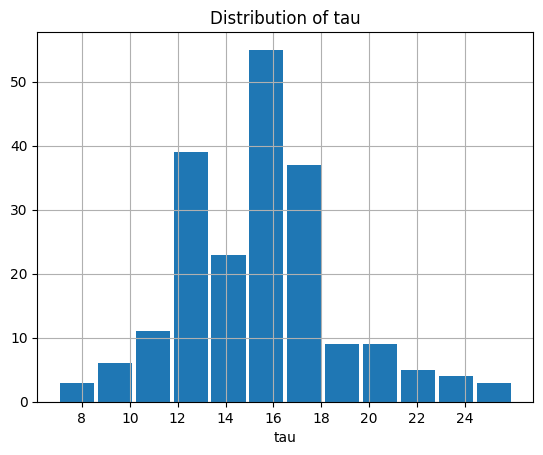

In [58]:
pd.Series([get_tau(df_train.iloc[i, :-1]) for i in range(df_train.shape[0])]).hist(
    rwidth=0.9,
    bins=12,
)
plt.title("Distribution of tau")
plt.xticks([i * 2 for i in range(4, 13)])
plt.xlabel("tau")
plt.show()

In [9]:
def standardize(ts):
    return (ts - np.min(ts)) / (np.ptp(ts) + 1e-9)

Test out the method:

In [62]:
LLM = LocalLinearMaps(W=2_000, n_iter=1000, T=100)
L = LLM.get_exponents(standardize(df_train.iloc[10, :-1]).values)
print(f"Best m: {LLM.m}, best tau: {LLM.tau}")
print(f"Lyapunov spectrum: {L}")

Best m: 3, best tau: 12
Lyapunov spectrum: [-0.13759142 -0.15034004 -0.48582596]


### Entropy-complexity plane

In order to get a better understanding of how the data points are distributed on the entropy-complexity plane I take a random subsample from train and find entropies and complexities for each series in it. Here blue points are normal series and orange points are abnormal.

Plotting entropy-complexity plane:   0%|          | 0/80 [00:00<?, ?it/s]

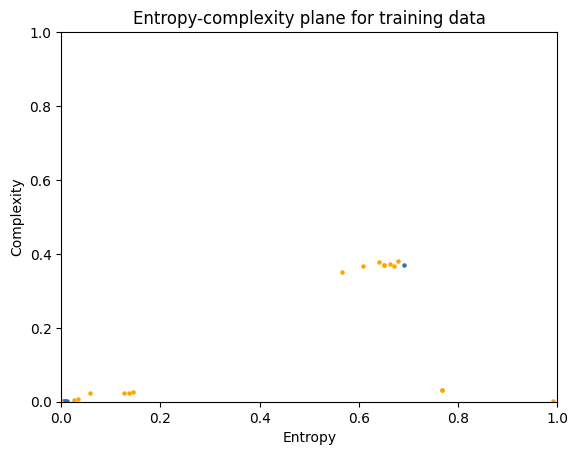

In [11]:
from math import factorial

import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon


def entropy_complexity(ts, m: int | None = None):
    """
    Calculate the entropy and complexity of a particular time series.
    """
    m = max(2, get_emb_size(ts, get_tau(ts))) if m is None else m
    nbins = min(len(ts) // 2, factorial(m))
    hist, _ = np.histogram(ts, bins=nbins, range=(0, 1), density=True)
    hist = hist / hist.sum()  # normalize

    H = -np.sum(hist * np.log(hist + 1e-9))
    H /= np.log(len(hist))  # normalize to [0,1]

    uniform = np.ones_like(hist) / len(hist)
    JSD = jensenshannon(hist, uniform, base=np.e) ** 2

    C = JSD * H
    return H, C


rand_ids = np.random.randint(0, df_train.shape[0], size=(80,))
for i in tqdm(rand_ids, desc="Plotting entropy-complexity plane"):
    H, C = entropy_complexity(df_train.iloc[i, :-1].values)
    plt.scatter(H, C, c="#1f77b4" if df_train.iloc[i, -1] == 0 else "orange", s=5.0)

plt.title("Entropy-complexity plane for training data")
plt.ylabel("Complexity")
plt.xlabel("Entropy")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

This may imply that the normal series are closer to regular series, while abnormal obersations correspond closer to colored noises

### Collecting the datasets

Now I collect train and test datasets for the classifiers that will be used later in this work. Here I find the 5 Lyaponov exponents for a system since I use embedding size of 5.

In [12]:
train = {}
m = 5
for i in trange(df_train.shape[0]):
    ts = standardize(df_train.iloc[i, :-1]).values
    LLM = LocalLinearMaps(m=m, W=2_000, n_iter=1000, n_epochs=10, T=100)
    lyapunov_exps = LLM.get_exponents(ts)
    H, C = entropy_complexity(ts, m=m)
    train[i] = dict()
    for j, exp in enumerate(lyapunov_exps):
        train[i][f"exp_{j+1}"] = exp
    train[i].update(
        {
            "mean": df_train.iloc[i, :-1].values.mean(),
            "variance": df_train.iloc[i, :-1].values.ptp(),
            "entropy": H,
            "complexity": C,
            "target": df_train.iloc[i, -1],
        }
    )

train = pd.DataFrame.from_dict(train, orient="index")

  0%|          | 0/204 [00:00<?, ?it/s]

In [13]:
test = {}
m = 5
for i in trange(df_test.shape[0]):
    ts = standardize(df_test.iloc[i, :-1]).values
    LLM = LocalLinearMaps(m=m, W=2_000, n_iter=1000, n_epochs=10, T=100)
    lyapunov_exps = LLM.get_exponents(ts)
    H, C = entropy_complexity(ts, m=m)
    test[i] = dict()
    for j, exp in enumerate(lyapunov_exps):
        test[i][f"exp_{j+1}"] = exp
    test[i].update(
        {
            "mean": df_test.iloc[i, :-1].values.mean(),
            "variance": df_test.iloc[i, :-1].values.ptp(),
            "entropy": H,
            "complexity": C,
            "target": df_test.iloc[i, -1],
        }
    )

test = pd.DataFrame.from_dict(test, orient="index")

  0%|          | 0/205 [00:00<?, ?it/s]

### Hurst exponent

I decided to add Hurst exponents to the my datasets. Since the series are more than likely stationary, I use R / S ananlysis algorithm.

In [14]:
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.linear_model import LinearRegression


def RSAnalysis(series):
    i_max = int(np.floor(np.log(len(series) / 2) / np.log(10)))
    normalized_ranges = np.zeros((i_max))

    for i in range(1, i_max + 1):
        n = np.power(10, i)
        intervals = sliding_window_view(series, n)
        m, _ = intervals.shape

        means = intervals.mean(axis=1)
        S = intervals.std(axis=1)

        Y = np.cumsum((intervals - means.reshape(-1, 1)), axis=1)

        ranges = np.max(intervals, axis=1) - np.min(intervals, axis=1)
        normalized_ranges[i - 1] = (ranges / (S + 1e-9)).mean()

    linreg = LinearRegression().fit(
        np.array([i for i in range(1, i_max + 1)]).reshape(-1, 1),
        np.log(normalized_ranges),
    )
    return linreg.coef_, linreg.intercept_


H_vals = np.zeros((df_train.shape[0],))
for i in trange(df_train.shape[0], desc="Gathering Hurst exponents for train"):
    H_vals[i] = RSAnalysis(df_train.iloc[i, :-1].values)[0][0]

train["hurst_exp"] = H_vals

H_vals = np.zeros((df_test.shape[0],))
for i in trange(df_test.shape[0], desc="Gathering Hurst exponents for test"):
    H_vals[i] = RSAnalysis(df_test.iloc[i, :-1].values)[0][0]

test["hurst_exp"] = H_vals

Gathering Hurst exponents for train:   0%|          | 0/204 [00:00<?, ?it/s]

Gathering Hurst exponents for test:   0%|          | 0/205 [00:00<?, ?it/s]

## Model training & inference

First, let us take a look at the dataset I used.

### 5 Lyapunov exponents

In [41]:
X_train, y_train = train.drop(["target"], axis=1), train["target"]
X_test, y_test = test.drop(["target"], axis=1), test["target"]
X_test

,exp_1,exp_2,exp_3,exp_4,exp_5,mean,variance,entropy,complexity,hurst_exp
0,-0.167081,-0.232580,-0.267592,-0.282849,-0.329739,-0.000072,0.244934,0.725657,0.229107,0.443842
1,-0.213846,-0.284474,-0.343955,-0.368544,-0.404318,-0.000027,1.045074,0.546594,0.224430,0.623944
2,-0.183789,-0.237129,-0.282105,-0.285985,-0.286724,-0.000218,1.088959,0.750532,0.213225,0.488059
3,-0.155886,-0.226126,-0.255397,-0.260022,-0.333757,-0.000026,0.443878,0.616748,0.244783,0.514958
4,-0.235820,-0.291780,-0.312325,-0.354715,-0.396337,0.000066,0.990601,0.613272,0.229824,0.592342
...,...,...,...,...,...,...,...,...,...,...
200,-0.218210,-0.284104,-0.352976,-0.386200,-0.437884,-0.000028,1.333679,0.487909,0.220562,0.555663
201,-0.146492,-0.241173,-0.227633,-0.288969,-0.317053,0.000003,0.833283,0.734478,0.222855,0.481915
202,-0.228437,-0.252163,-0.285391,-0.332489,-0.386447,0.000012,0.785553,0.642072,0.240110,0.610795
203,-0.259518,-0.277499,-0.329814,-0.344534,-0.463638,0.000035,0.588196,0.631402,0.239240,0.652130


In [45]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
)

results = dict()
cls_weights = {
    0: 64,
    1: 40,
}  # Since classses are imbalanced, let us try adding class weights

for name, cls in zip(
    ["DecisionTree", "LogReg", "SVC"],
    [
        DecisionTreeClassifier(class_weight=cls_weights),
        LogisticRegression(class_weight=cls_weights),
        SVC(class_weight=cls_weights),
    ],
):
    cls.fit(X_train, y_train)
    y_pred_train = cls.predict(X_train)
    y_pred_test = cls.predict(X_test)

    results[("train", name)] = dict()
    for metric, func in zip(
        ["Accuracy", "Recall", "Precision", "F1", "ROC-AUC"],
        [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score],
    ):
        results[("train", name)][metric] = func(y_train, y_pred_train)

    results[("test", name)] = dict()
    for metric, func in zip(
        ["Accuracy", "Recall", "Precision", "F1", "ROC-AUC"],
        [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score],
    ):
        results[("test", name)][metric] = func(y_test, y_pred_test)


results = pd.DataFrame.from_dict(results, orient="index").sort_index()
results

Accuracy    Recall  Precision        F1   ROC-AUC
test  DecisionTree  0.609756  0.760000   0.721519  0.740260  0.480000
      LogReg        0.726829  0.846667   0.793750  0.819355  0.623333
      SVC           0.687805  0.760000   0.802817  0.780822  0.625455
train DecisionTree  1.000000  1.000000   1.000000  1.000000  1.000000
      LogReg        0.774510  0.885906   0.819876  0.851613  0.679317
      SVC           0.808824  0.872483   0.866667  0.869565  0.754423

In [21]:
train.to_csv(join("data", "train_data_5_exponents.csv"), index=False)
test.to_csv(join("data", "test_data_5_exponents.csv"), index=False)

### 8 Lyapunov exponents

I have results from using `m = 8`, let us try them too (completely optional)

In [17]:
train_8 = pd.read_csv(join("data", "train_data_8_exponents.csv"))
test_8 = pd.read_csv(join("data", "test_data_8_exponents.csv"))

In [18]:
X_train, y_train = train_8.drop(["target"], axis=1), train_8["target"]
X_test, y_test = test_8.drop(["target"], axis=1), test_8["target"]
X_test

,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_7,exp_8,mean,variance,entropy,complexity,hurst_exp
0,-0.170599,-0.200524,-0.231252,-0.239443,-0.256033,-0.267040,-0.298894,-0.347257,-0.000072,0.244934,0.710647,0.410702,0.443842
1,-0.232853,-0.235450,-0.288792,-0.316797,-0.320500,-0.331685,-0.369278,-0.425215,-0.000027,1.045074,0.746758,0.398502,0.623944
2,-0.187532,-0.196392,-0.238754,-0.224970,-0.266743,-0.256721,-0.300748,-0.327588,-0.000218,1.088959,0.829814,0.362445,0.488059
3,-0.172500,-0.197323,-0.205073,-0.241146,-0.255474,-0.270467,-0.296771,-0.369941,-0.000026,0.443878,0.713523,0.408458,0.514958
4,-0.238819,-0.283862,-0.290834,-0.312633,-0.347619,-0.346601,-0.391471,-0.450487,0.000066,0.990601,0.769826,0.396588,0.592342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-0.222012,-0.277134,-0.293508,-0.292542,-0.331678,-0.358723,-0.373609,-0.472023,-0.000028,1.333679,0.735566,0.403319,0.555663
201,-0.150439,-0.221581,-0.211548,-0.236685,-0.244667,-0.245482,-0.281426,-0.371908,0.000003,0.833283,0.808150,0.379616,0.481915
202,-0.185169,-0.233795,-0.278698,-0.283028,-0.318455,-0.314102,-0.336135,-0.391847,0.000012,0.785553,0.768241,0.400287,0.610795
203,-0.230316,-0.280074,-0.307141,-0.323694,-0.357955,-0.341819,-0.361087,-0.495778,0.000035,0.588196,0.740728,0.405264,0.652130


In [19]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
)

results = dict()
cls_weights = {
    0: 66,
    1: 44,
}  # Since classses are imbalanced, let us try adding class weights

for name, cls in zip(
    ["DecisionTree", "LogReg", "SVC"],
    [
        DecisionTreeClassifier(class_weight=cls_weights),
        LogisticRegression(class_weight=cls_weights),
        SVC(class_weight=cls_weights),
    ],
):
    cls.fit(X_train, y_train)
    y_pred_train = cls.predict(X_train)
    y_pred_test = cls.predict(X_test)

    results[("train", name)] = dict()
    for metric, func in zip(
        ["Accuracy", "Recall", "Precision", "F1", "ROC-AUC"],
        [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score],
    ):
        results[("train", name)][metric] = func(y_train, y_pred_train)

    results[("test", name)] = dict()
    for metric, func in zip(
        ["Accuracy", "Recall", "Precision", "F1", "ROC-AUC"],
        [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score],
    ):
        results[("test", name)][metric] = func(y_test, y_pred_test)


results = pd.DataFrame.from_dict(results, orient="index").sort_index()
results

Accuracy    Recall  Precision        F1   ROC-AUC
test  DecisionTree  0.619512  0.760000   0.730769  0.745098  0.498182
      LogReg        0.721951  0.846667   0.788820  0.816720  0.614242
      SVC           0.687805  0.786667   0.786667  0.786667  0.602424
train DecisionTree  1.000000  1.000000   1.000000  1.000000  1.000000
      LogReg        0.779412  0.885906   0.825000  0.854369  0.688408
      SVC           0.794118  0.899329   0.832298  0.864516  0.704210

In [20]:
pd.Series(y_pred_test).value_counts() / len(y_pred_test)

1    0.731707
0    0.268293
Name: count, dtype: float64

### 1 Lyapunov exponent

Let us also conduct a test for data with only the largest Lyapunov exponent

In [33]:
X_train, y_train = (
    train.drop([f"exp_{i}" for i in range(2, 6)] + ["target"], axis=1),
    train["target"],
)
X_test, y_test = (
    test.drop([f"exp_{i}" for i in range(2, 6)] + ["target"], axis=1),
    test["target"],
)
X_test

,exp_1,mean,variance,entropy,complexity,hurst_exp
0,-0.167081,-0.000072,0.244934,0.725657,0.229107,0.443842
1,-0.213846,-0.000027,1.045074,0.546594,0.224430,0.623944
2,-0.183789,-0.000218,1.088959,0.750532,0.213225,0.488059
3,-0.155886,-0.000026,0.443878,0.616748,0.244783,0.514958
4,-0.235820,0.000066,0.990601,0.613272,0.229824,0.592342
...,...,...,...,...,...,...
200,-0.218210,-0.000028,1.333679,0.487909,0.220562,0.555663
201,-0.146492,0.000003,0.833283,0.734478,0.222855,0.481915
202,-0.228437,0.000012,0.785553,0.642072,0.240110,0.610795
203,-0.259518,0.000035,0.588196,0.631402,0.239240,0.652130


In [40]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
)

results = dict()
cls_weights = {
    0: 69,
    1: 41,
}  # Since classses are imbalanced, let us try adding class weights

for name, cls in zip(
    ["DecisionTree", "LogReg", "SVC"],
    [
        DecisionTreeClassifier(class_weight=cls_weights),
        LogisticRegression(class_weight=cls_weights),
        SVC(class_weight=cls_weights),
    ],
):
    cls.fit(X_train, y_train)
    y_pred_train = cls.predict(X_train)
    y_pred_test = cls.predict(X_test)

    results[("train", name)] = dict()
    for metric, func in zip(
        ["Accuracy", "Recall", "Precision", "F1", "ROC-AUC"],
        [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score],
    ):
        results[("train", name)][metric] = func(y_train, y_pred_train)

    results[("test", name)] = dict()
    for metric, func in zip(
        ["Accuracy", "Recall", "Precision", "F1", "ROC-AUC"],
        [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score],
    ):
        results[("test", name)][metric] = func(y_test, y_pred_test)


results = pd.DataFrame.from_dict(results, orient="index").sort_index()
results

Accuracy    Recall  Precision        F1   ROC-AUC
test  DecisionTree  0.648780  0.753333   0.763514  0.758389  0.558485
      LogReg        0.736585  0.846667   0.803797  0.824675  0.641515
      SVC           0.678049  0.746667   0.800000  0.772414  0.618788
train DecisionTree  1.000000  1.000000   1.000000  1.000000  1.000000
      LogReg        0.774510  0.872483   0.828025  0.849673  0.690787
      SVC           0.813725  0.865772   0.877551  0.871622  0.769250